Прообраз: https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb

In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [2]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [3]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print("Количество слов в словаре:", dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)


# Фильтрация

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=2000)
print(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)

# Убираются слова, которые попадаются всего в n процентов документов
dictionary.filter(min_df_rate=0.01)
print(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries)

Количество слов в словаре: 75725
75180
19310
1819


In [4]:
def new_default_model(topic_count, dictionary):
    # Создание модели
    model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(topic_count)], 
                           cache_theta=True,
                           #class_ids={'text': 1.0},
                          )

    # Инициализация модели
    model_artm.initialize(dictionary=dictionary)
    model_artm.num_document_passes = 1

    # Установка отслеживаемых параметров
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
    #model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
    
    return model_artm

In [5]:
def model_print_results(model_artm):
    
    # Графики
    
    fig = plt.figure(figsize=(15, 10))

    ax1 = fig.add_subplot(221)   #top left
    ax1.plot(model_artm.score_tracker["SparsityPhiScore"].value)
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('SparsityPhiScore')
    ax1.grid(True)

    ax2 = fig.add_subplot(222)   #top right
    ax2.plot(model_artm.score_tracker["SparsityThetaScore"].value)
    ax2.set_xlabel('Iterations count')
    ax2.set_ylabel('SparsityThetaScore')
    ax2.grid(True)

    ax3 = fig.add_subplot(223)   #bottom left
    ax3.plot(model_artm.score_tracker["PerplexityScore"].value)
    ax3.set_xlabel('Iterations count')
    ax3.set_ylabel('PerplexityScore')
    ax3.grid(True)

    plt.show()
    
    
    # Конечные значения
    
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    
    
    # Главные слова в темах
    
    topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())
    for topic_name in topic_list:
        print(topic_name + ': ', end='')
        print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

Примеры:
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_tutorial_RU.ipynb
* http://localhost:8888/notebooks/examples/2/%D0%94%D0%B5%D0%BC%D0%BE%D0%BD%D1%81%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F-BigARTM-0.8.0.ipynb

In [10]:
params = {
    'topic_count': 100,
    'num_collection_passes': 50,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -1.5
    },
}

In [11]:
# Базовая пустая модель
model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.save("news_model_0")

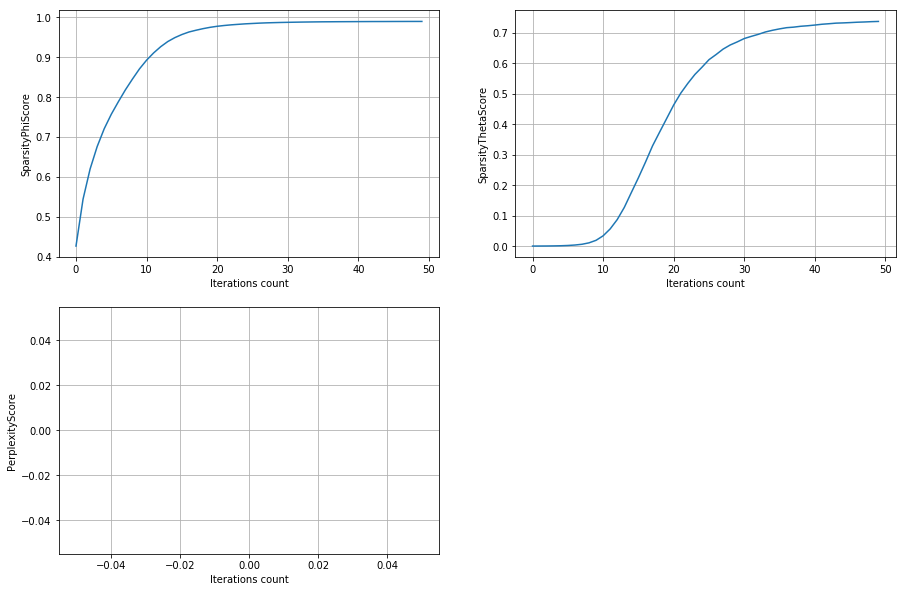

SparsityPhiScore: 0.989587664604187
SparsityThetaScore: 0.7371256351470947

topic_0: ['обращать', 'хорошо', 'поставлять', 'технический', 'скоро', 'записывать', 'заходить', 'носить', 'ездить', 'съемка']
topic_1: ['сторонник', 'организовывать', 'вячеслав', 'волков', 'собрание', 'волк', 'леонид', 'кампания', 'согласовывать', 'расследовать']
topic_2: ['соглашаться', 'отсутствие', 'важный', 'правда', 'оправдывать', 'немой', 'смысл', 'приятель', 'пойти', 'солдат']
topic_3: ['имущество', 'банк', 'строительство', 'похищать', 'услуга', 'связанный', 'бюджет', 'увольнение', 'выплата', 'рост']
topic_4: ['студент', 'бросать', 'способ', 'университет', 'стена', 'наркотический', 'сбыт', 'отбирать', 'поле', 'посетитель']
topic_5: ['кабинет', 'максим', 'причастность', 'округ', 'частный', 'артем', 'избрание', 'школьник', 'полгода', 'класс']
topic_6: ['здесь', 'читать', 'оглашать', 'перерыв', 'нельзя', 'голос', 'возражать', 'выступление', 'пользоваться', 'михайлов']
topic_7: ['напоминать', 'паспорт', 'пой

topic_62: ['ударять', 'превышение', 'причинение', 'условно', 'причинять', 'умышленный', 'неосторожность', 'ленинский', 'опасный', 'челябинский']
topic_63: ['родитель', 'подобный', 'война', 'выражать', 'ролик', 'православный', 'кремль', 'мама', 'вокруг', 'определение']
topic_64: ['операция', 'четверо', 'кадыров', 'чеченский', 'грозный', 'структура', 'группировка', 'боевик', 'ранить', 'исламский']
topic_65: ['изолятор', 'гибель', 'надежда', 'держать', 'кровь', 'жаловаться', 'медик', 'временный', 'диагностировать', 'шизо']
topic_66: ['полагать', 'мало', 'самолет', 'единственный', 'всего', 'купить', 'соответствие', 'четверг', 'подымать', 'аппарат']
topic_67: ['сначала', 'нужно', 'ольга', 'наручник', 'лежать', 'присутствовать', 'защищать', 'объяснение', 'знак', 'клиент']
topic_68: ['удаваться', 'десять', 'кража', 'вернуть', 'карта', 'роман', 'драка', 'мобильный', 'отправляться', 'одиночный']
topic_69: ['госдума', 'телеканал', 'канал', 'редакция', 'дождь', 'публиковать', 'информационный', 'р

In [12]:
# Модель 1
# Запуск регуляризатора SparsePhi

model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.load("news_model_0")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_1")

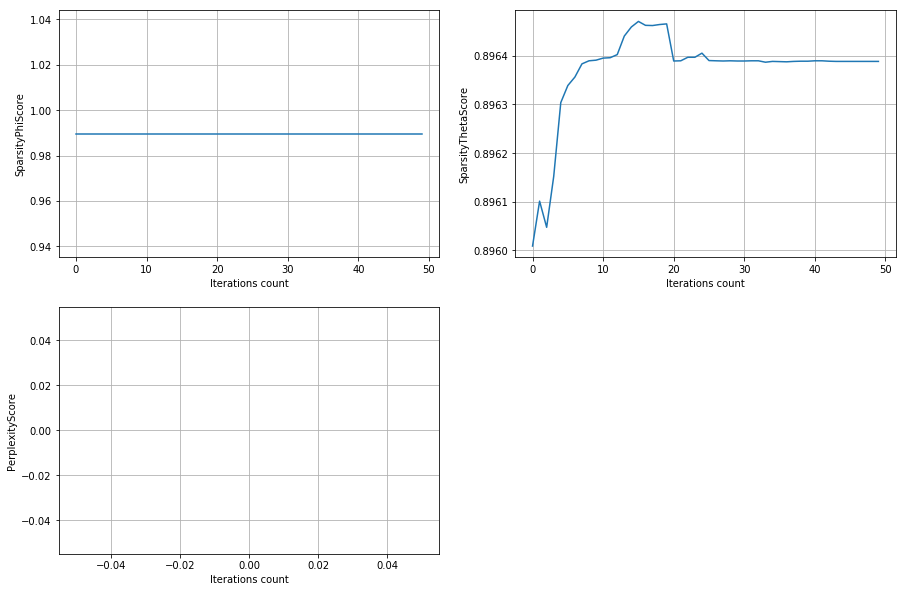

SparsityPhiScore: 0.989587664604187
SparsityThetaScore: 0.8963887691497803

topic_0: ['хорошо', 'обращать', 'поставлять', 'история', 'скоро', 'нужно', 'технический', 'записывать', 'заходить', 'ездить']
topic_1: ['волков', 'сторонник', 'волк', 'леонид', 'вячеслав', 'организовывать', 'собрание', 'кампания', 'согласовывать', 'президентский']
topic_2: ['соглашаться', 'отсутствие', 'правда', 'важный', 'оправдывать', 'солдат', 'смысл', 'письменный', 'приятель', 'немой']
topic_3: ['банк', 'строительство', 'имущество', 'услуга', 'похищать', 'бюджет', 'связанный', 'выплата', 'увольнение', 'рост']
topic_4: ['студент', 'бросать', 'университет', 'наркотический', 'стена', 'сбыт', 'способ', 'грамм', 'поле', 'посетитель']
topic_5: ['кабинет', 'максим', 'причастность', 'частный', 'округ', 'школьник', 'артем', 'класс', 'полгода', 'избрание']
topic_6: ['читать', 'оглашать', 'перерыв', 'нельзя', 'голос', 'возражать', 'михайлов', 'выступление', 'пользоваться', 'уверенный']
topic_7: ['пойти', 'паспорт', 'д

topic_63: ['родитель', 'война', 'подобный', 'ролик', 'мама', 'православный', 'кремль', 'выражать', 'вокруг', 'определение']
topic_64: ['кадыров', 'грозный', 'чеченский', 'операция', 'боевик', 'группировка', 'четверо', 'структура', 'исламский', 'ранить']
topic_65: ['изолятор', 'гибель', 'надежда', 'кровь', 'держать', 'медик', 'временный', 'шизо', 'клетка', 'диагностировать']
topic_66: ['самолет', 'мало', 'единственный', 'полагать', 'купить', 'всего', 'подымать', 'соответствие', 'аппарат', 'несмотря']
topic_67: ['сначала', 'ольга', 'нужно', 'лежать', 'наручник', 'защищать', 'присутствовать', 'объяснение', 'знак', 'обычно']
topic_68: ['удаваться', 'кража', 'десять', 'карта', 'вернуть', 'драка', 'роман', 'мобильный', 'отправляться', 'одиночный']
topic_69: ['госдума', 'телеканал', 'канал', 'редакция', 'дождь', 'телегр', 'редактор', 'информационный', 'журналистка', 'поправка']
topic_70: ['взрыв', 'устройство', 'хранение', 'кавказский', 'взрывной', 'дагестан', 'село', 'ингушетия', 'узел', 'ав

In [13]:
# Модель 2
# Запуск регуляризатора SparseTheta

model_artm = new_default_model(params['topic_count'], dictionary)
model_artm.load("news_model_1")

if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']
    
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])
model_print_results(model_artm)

model_artm.save("news_model_2")

In [ ]:
SparsityPhiScore: 0.8874656558036804
SparsityThetaScore: 0.6712796092033386

In [ ]:
SparsityPhiScore: 0.8848817944526672
SparsityThetaScore: 0.4675273895263672

In [ ]:
SparsityPhiScore: 0.9008246064186096
SparsityThetaScore: 0.47223731875419617

In [67]:
topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())

for topic_name in topic_list:
    print(topic_name + ': ', end='')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: ['специалист', 'например', 'цена', 'исследование', 'передача', 'технический', 'использовать', 'высокий', 'следовать', 'подобный']
topic_1: ['партия', 'волков', 'волк', 'сторонник', 'оппозиционер', 'инфо', 'публичный', 'пикет', 'подпись', 'леонид']
topic_2: ['доказывать', 'обвинительный', 'преступный', 'николай', 'полностью', 'полагать', 'вновь', 'соглашаться', 'ссылаться', 'тяжкий']
topic_3: ['предприятие', 'зарплата', 'министр', 'банк', 'долг', 'бизнесмен', 'млрд', 'чиновник', 'счет', 'строительство']
topic_4: ['устройство', 'вещество', 'родитель', 'лагерь', 'звонок', 'магазин', 'торговый', 'взрывной', 'студент', 'советский']
topic_5: ['подросток', 'пожар', 'детский', 'несовершеннолетний', 'мальчик', 'погибший', 'возраст', 'отец', 'служебный', 'гибель']
topic_6: ['читать', 'задавать', 'оглашать', 'перерыв', 'напоминать', 'возражать', 'помнить', 'карта', 'общаться', 'осмотр']
topic_7: ['зачитывать', 'нужный', 'след', 'вещь', 'поехать', 'паспорт', 'действительно', 'взрыв', 'ста

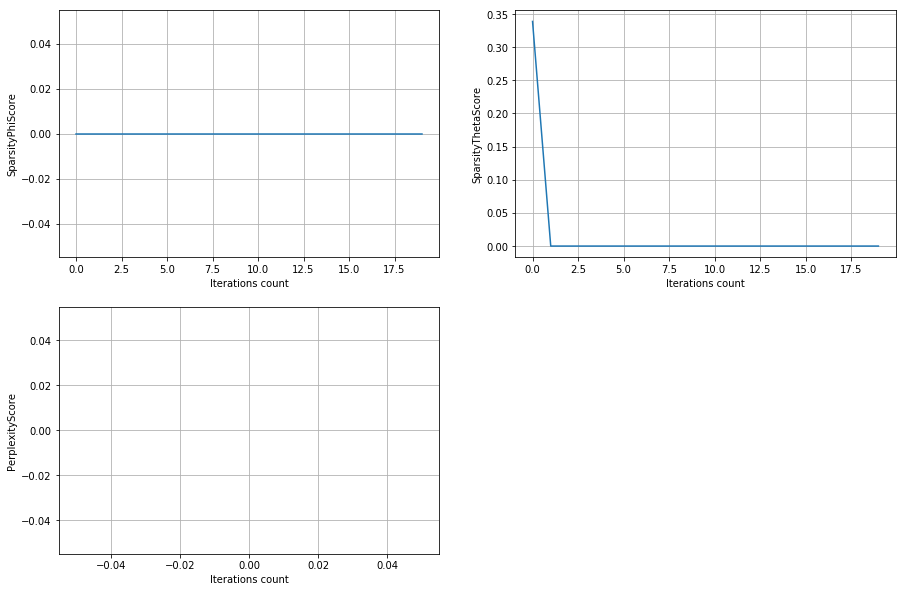

SparsityPhiScore: 0.0
SparsityThetaScore: 0.0


In [11]:
# Модель 3
# Запуск регуляризатора SparseTheta

model_artm = new_default_model(topic_count, dictionary)

model_artm.load("news_model_2")

model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='TopicSelectionTheta'))
model_artm.regularizers['TopicSelectionTheta'].tau = 1

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)
model_print_results(model_artm)

model_artm.save("news_model_3")

In [34]:
#topic_list = model_artm.topic_names
topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())

for topic_name in topic_list:
    print(topic_name + ': ', end='')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: ['специалист', 'вывод', 'исследование', 'любой', 'например', 'высокий', 'подобный', 'технический', 'использовать', 'возможность']
topic_1: ['партия', 'оппозиционер', 'инфо', 'публичный', 'открытый', 'сторонник', 'оштрафовать', 'твиттер', 'волков', 'борьба']
topic_2: ['обвинительный', 'эпизод', 'кража', 'соглашаться', 'давление', 'добиваться', 'вадим', 'полагать', 'доказывать', 'признаваться']
topic_3: ['предприятие', 'особо', 'бизнесмен', 'мошенничество', 'миллион', 'министр', 'банк', 'зарплата', 'счет', 'чиновник']
topic_4: ['родитель', 'устройство', 'хранение', 'вещество', 'звонок', 'магазин', 'студент', 'правда', 'лагерь', 'взрывной']
topic_5: ['подросток', 'несовершеннолетний', 'гибель', 'проводиться', 'пожар', 'детский', 'мальчик', 'округ', 'погибший', 'рождение']
topic_6: ['выборы', 'читать', 'напоминать', 'подпись', 'оглашать', 'никита', 'обсуждать', 'задавать', 'перерыв', 'позиция']
topic_7: ['взрыв', 'паспорт', 'тюрьма', 'станция', 'вещь', 'минута', 'хороший', 'мост',

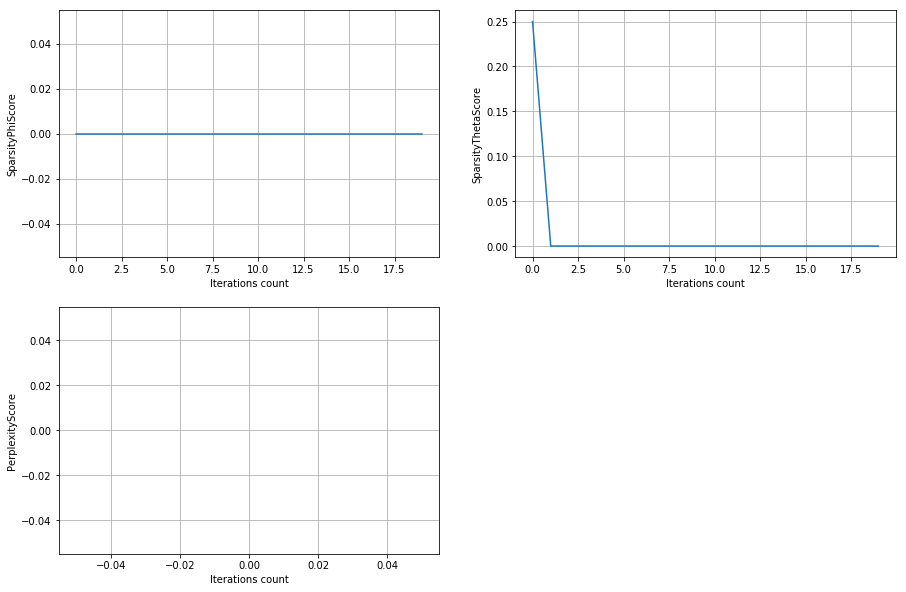

SparsityPhiScore: 0.0
SparsityThetaScore: 0.0


In [11]:
# Модель 3
# Запуск регуляризатора DecorrelatorPhi

model_artm = new_default_model(topic_count, dictionary)

model_artm.load("news_model_2")

model_artm.regularizers.add(artm.//(name='DecorrelatorPhi'))
model_artm.regularizers['DecorrelatorPhi'].tau = 0.1

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)
model_print_results(model_artm)

model_artm.save("news_model_3")

In [12]:
model_artm.regularizers

[DecorrelatorPhi]

In [131]:
# Установка регуляризаторов
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi'))
#model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta'))
#model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi'))


#model_artm.regularizers.add(artm.TopicSelectionThetaRegularizer(name='TopicSelectionTheta', tau=0.1))

In [132]:
# Правка регуляризаторов
model_artm.regularizers['SparsePhi'].tau = -3
#model_artm.regularizers['SparseTheta'].tau = -2
#model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [136]:
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta'))
model_artm.regularizers['SparseTheta'].tau = -2

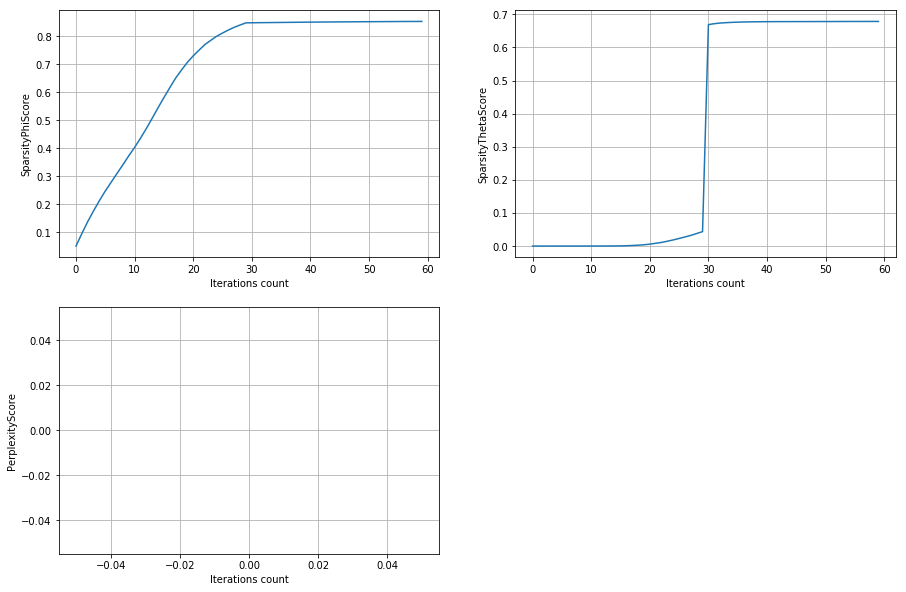

SparsityPhiScore: 0.85197913646698
SparsityThetaScore: 0.6784400939941406


In [137]:
# Первичное обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)
model_results(model_artm)

In [22]:
#topic_list = model_artm.topic_names
topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())

for topic_name in topic_list:
    print(topic_name + ': ', end='')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: ['использовать', 'специалист', 'разный', 'вывод', 'передача', 'оперативный', 'обращать', 'основной', 'операция', 'обсуждать']
topic_1: ['партия', 'публичный', 'вконтакте', 'лидер', 'инфо', 'оппозиционер', 'борьба', 'оштрафовать', 'сторонник', 'организовывать']
topic_2: ['тяжкий', 'семь', 'соглашаться', 'третий', 'внутренний', 'освобождать', 'отсутствие', 'позиция', 'следовать', 'вскоре']
topic_3: ['предприятие', 'бизнесмен', 'мошенничество', 'министр', 'миллион', 'рабочий', 'чиновник', 'счет', 'имущество', 'банк']
topic_4: ['родитель', 'предмет', 'десять', 'устройство', 'иван', 'вещество', 'вернуть', 'черный', 'звонок', 'магазин']
topic_5: ['служебный', 'подросток', 'несовершеннолетний', 'настоящий', 'проводиться', 'гибель', 'центральный', 'кабинет', 'обязанность', 'привлекать']
topic_6: ['возможность', 'поддерживать', 'нужно', 'выборы', 'напоминать', 'участок', 'здесь', 'задавать', 'подпись', 'любой']
topic_7: ['коллега', 'пойти', 'закрывать', 'взрыв', 'полагать', 'встречатьс

In [25]:
model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-5*1e5, dictionary=dictionary),
    overwrite=True,
)

In [30]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

In [31]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ',)
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['использовать', 'нужно', 'создавать', 'третий', 'почти', 'отсутствие']
topic_1: 
['партия', 'призыв', 'социальный', 'публичный', 'телеканал', 'политика']
topic_2: 
['николай', 'юрий', 'сообщество', 'потребовать', 'изолятор', 'прекращать']
topic_3: 
['особо', 'предприятие', 'бизнесмен', 'мошенничество', 'занимать', 'должность']
topic_4: 
['сидеть', 'отец', 'вспоминать', 'дверь', 'бить', 'правый']
topic_5: 
['служебный', 'ударять', 'превышение', 'повреждение', 'подросток', 'умирать']
topic_6: 
['помнить', 'поддерживать', 'минута', 'коллега', 'событие', 'снова']
topic_7: 
['покушение', 'известный', 'официальный', 'подозревать', 'офис', 'борис']
topic_8: 
['возможность', 'иностранный', 'госдума', 'подписывать', 'министерство', 'список']
topic_9: 
['удаваться', 'пистолет', 'угрожать', 'накануне', 'открывать', 'проводиться']


In [32]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.8992853164672852
0.20184320211410522


Полезные идеи по нулевым значениям:
https://github.com/bigartm/bigartm/issues/664

In [38]:
model_artm.score_tracker

{'PerplexityScore': <artm.score_tracker.PerplexityScoreTracker at 0x104a838d0>,
 'SparsityPhiScore': <artm.score_tracker.SparsityPhiScoreTracker at 0x10ed47c88>,
 'SparsityThetaScore': <artm.score_tracker.SparsityThetaScoreTracker at 0x10ed47cf8>,
 'TopTokensScore': <artm.score_tracker.TopTokensScoreTracker at 0x1119dcbe0>,
 'TopicKernelScore': <artm.score_tracker.TopicKernelScoreTracker at 0x10ed47d30>}